Starting from a 
* pre-trained model with a 
* pre-trained tokenizer

we perform finetuning on a negation task

Tweakable:
* test-time augmentation
* flattening B-, I-
* block-size
* batch-size
* gradient

Experiments:
* (negation paper) 32 block size, 32 batch size, with/without centered validation
  * MedRoBERTa.nl
  * RobBERT v2
* 32 block size, 32 batch size, with centered validation, 1-12 layers 
  * MedRoBERTa.nl
  * RobBERT v2

In [1]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import dotenv
import numpy as np
import random
from tqdm import tqdm

try:
    from torch.nn import CrossEntropyLoss
except ImportError:
    # load .env
    dotenv.load_dotenv(dotenv.find_dotenv())
    os.environ['LD_LIBRARY_PATH'] = os.getenv('LD_LIBRARY_PATH')
    from torch.nn import CrossEntropyLoss
    

from torch.utils.data import Dataset, DataLoader
from torch import device, cuda, version

#import apex
import pandas as pd

import seaborn
import matplotlib.pyplot as plt

from collections import namedtuple
from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForTokenClassification
from transformers import AutoModelForSequenceClassification

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import dcc_splitter as splitter
from utils import ner_training as trainer
#import dcc_splitter as splitter

use_gpu = True

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
if cuda.is_available():
    print('CUDA, GPU, is working')
    os.system("espeak 'CUDA, GPU, is working!'")
else:
    print('CUDA, GPU, is not working')
    os.system("espeak 'CUDA, GPU, is NOT working!'")
    
device = device("cuda:0") if (cuda.is_available()) & (use_gpu==True) else device("cpu")

CUDA, GPU, is working


In [27]:
#base_folder = "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels"
base_folder = "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models"

dcc_dir = None
output_dir = os.path.join(base_folder, "finetuned")
skip_file = '../data/EMCDutchClinicalCorpus/DCC_files_to_exclude.json'
n_splits = 10
random_state = 42
reduce_tags = False
centered_testing = True
train_on_all = True
zero_shot = False # do not train the attention layers, only the final linear layer
#num_trainable_layers = None # None: all, overrides zero_shot
mod_name =  "finetuned/negation_512"  # "base/medroberta"

args = namedtuple
args.task = "experiencer" # experiencer, temporality, negation
args.model_path = os.path.join(base_folder, mod_name)
args.model_type = "roberta" # bertje 
args.num_epochs = 5 # 10 for zero-shot
args.eval_steps = 500 
args.lr =  4e-5 # 5e-5 for non-zeroshot 64 bs, 5e-3 for zero-shot 128 bs, 1e-4 for nonzeroshot 32 bs
args.batch_size= 32 #4
args.gradient_accumulation_steps = 1 #16
args.block_size = 64 # 512 
args.save_model=True
args.bio=True
args.do_eval=True
args.do_write=True
args.bootstrap=False
args.do_print_class_report=False
args.amp=True

mod_name = mod_name.replace("/","_").replace("-","_")+"_"+"_".join([str(args.num_epochs), 
                                                   str(args.batch_size*args.gradient_accumulation_steps), 
                                                   str(args.block_size),
                                                   "zeroShot" if zero_shot else "",
                                                   "centeredVal" if centered_testing else "",
                                                   args.task])
mod_name = mod_name.strip("_")
output_folder = "fine_tuned_token_"+args.task+"_"+mod_name

args.output_dir = os.path.join(output_dir, output_folder)

# check if the output folder exists
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

random.seed(77)

In [26]:
args.output_dir

'//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\finetuned\\fine_tuned_token_experiencer_finetuned_negation_512_5_32_64__centeredVal_experiencer'

In [5]:
# args.block_size determines how many text snippets are  used for training, see ner_training.py lines 118--141
# obviously this is a code-design flaw that should be mended.
# the dataset loader should  include the id_begin_end in the output

In [6]:
# load NER DCC set
dcc = pd.read_csv("../data/DCC_df_ASL1_hypothetical.csv", 
                  sep="\t", 
                  skip_blank_lines=True, 
                  engine="python", 
                  encoding="latin1",
                  on_bad_lines='warn', 
                  keep_default_na=False)

In [7]:
dcc.Temporality.value_counts()

Temporality
O               199355
Recent           18860
Historical         822
Hypothetical       642
Name: count, dtype: int64

In [8]:
dcc.Negation.value_counts()

Negation
O             199840
NotNegated     16781
Negated         3058
Name: count, dtype: int64

In [9]:
dcc.Experiencer.value_counts()

Experiencer
O          198578
Patient     19676
Other        1425
Name: count, dtype: int64

In [10]:
dcc.BIO.value_counts()

BIO
O    198084
B     12934
I      8661
Name: count, dtype: int64

In [11]:
dcc.loc[dcc.BIO!='O'][['Id', 'Begin', 'End']].apply(lambda x: "_".join(str(x)), axis=1).nunique()

21595

In [12]:
Texts = dcc.groupby('Id').Word.apply(lambda x: " ".join(x))

In [13]:
if reduce_tags:
    tag_ids = {'negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':0,'I-NotNegated':1},
              'temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':0,
                             'I-Historical':1,'I-Hypothetical':2},
              'experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':0,'I-Other':1}}
else:
    tag_ids = {'negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':2,'I-NotNegated':3},
              'temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':3,
                             'I-Historical':4,'I-Hypothetical':5},
              'experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':2,'I-Other':3}}

tag2id = tag_ids[args.task]
tokenizer = AutoTokenizer.from_pretrained(args.model_path)

In [14]:
dcc['num_tokens'] = dcc.Word.apply(lambda x: len(tokenizer.tokenize(x)))
dcc['cumsum_tokens'] = dcc.groupby('Id').num_tokens.cumsum()
dcc['letter_type'] = dcc.Id.str.slice(0,2)
tokens_df = dcc.groupby(['Id', 'letter_type']).cumsum_tokens.agg(num_tokens=max).reset_index()

Mean 
DL tokens: 58.88821490467937
SP tokens :71.43517138599105
RD tokens :31.51384417256922
GP tokens :31.99592944369064


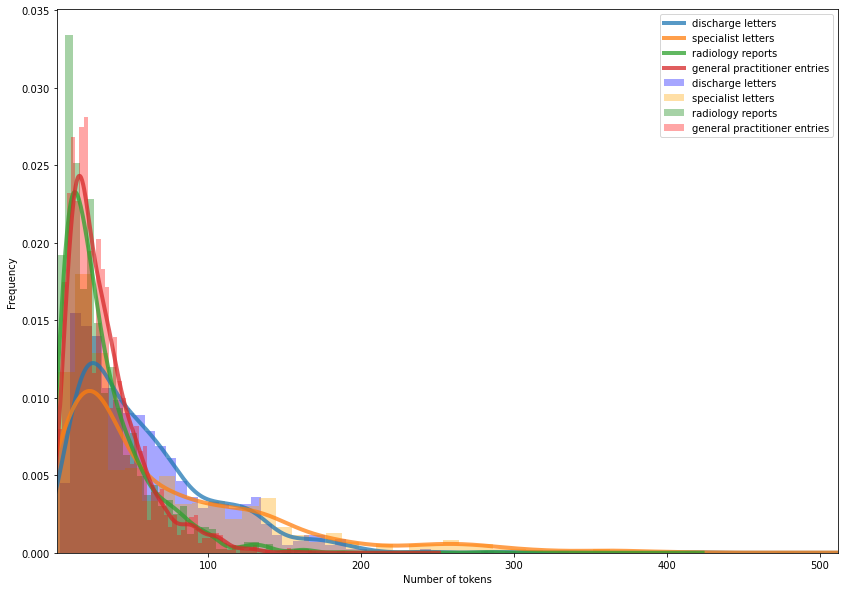

In [15]:
plt.figure(figsize=(14,10))
tokens_df[(tokens_df.letter_type=='DL')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='discharge letters')
tokens_df[(tokens_df.letter_type=='SP')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='specialist letters')
tokens_df[(tokens_df.letter_type=='RD')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='radiology reports')
tokens_df[(tokens_df.letter_type=='GP')]\
                        .num_tokens.plot.kde(lw=4, alpha=0.75, label='general practitioner entries')

tokens_df[(tokens_df.letter_type=='DL')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='blue',
                                              label='discharge letters')
tokens_df[(tokens_df.letter_type=='SP')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='orange',
                                              label='specialist letters')
tokens_df[(tokens_df.letter_type=='RD')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='green',
                                              label='radiology reports')
tokens_df[(tokens_df.letter_type=='GP')]\
                        .num_tokens.plot.hist(bins=60, alpha=0.35, density=True, color='red',
                                              label='general practitioner entries')


plt.legend()
#plt.semilogx()
plt.xlabel("Number of tokens")
plt.xlim(1,512)

print(f"Mean \nDL tokens: {tokens_df[(tokens_df.letter_type=='DL')].num_tokens.mean()}\n\
SP tokens :{tokens_df[(tokens_df.letter_type=='SP')].num_tokens.mean()}\n\
RD tokens :{tokens_df[(tokens_df.letter_type=='RD')].num_tokens.mean()}\n\
GP tokens :{tokens_df[(tokens_df.letter_type=='GP')].num_tokens.mean()}")

In [16]:
# find I that is not preceeded by a B..
def prior_equal_to(x, equal_to='O'):
    if isinstance(x, pd.Series):
        _x = np.array(x.values)
        xout= np.zeros_like(_x)
        for i in range(1, len(_x)):
            xout[i] = (_x[i-1] == equal_to)
        return xout
    else:
        x = np.nan
        return x

In [17]:
dcc['O_as_prior'] = dcc.groupby('Id').BIO.transform(prior_equal_to, equal_to='O')
dcc['I_as_prior'] = dcc.groupby('Id').BIO.transform(prior_equal_to,  equal_to='I')
dcc['SpecialChar_as_prior'] = dcc.groupby('Id').Word.transform(prior_equal_to,
                                                           **{'equal_to':['.', ',', ':', ';', 
                                                                          '!', '?','-','+']})

In [18]:
dcc.loc[(dcc.BIO=='I') & (dcc.O_as_prior==True), 'BIO'] = 'B'
dcc.loc[(dcc.BIO=='I') & (dcc.SpecialChar_as_prior==True), 'BIO'] = 'B'

In [19]:
# for centering, just change the dcc..
# improvement: add boolean to indicate whether entity is in center, process in training routine :)
sub_dfs = []
for _id in tqdm(dcc.Id.unique()):
    cst_list = dcc[(dcc.Id==_id) & (dcc.BIO=='B')].cumsum_tokens.to_list()
    for l, cst in enumerate(cst_list):
        sub_df = dcc[(dcc.Id==_id) & 
                (dcc.cumsum_tokens<cst+int(0.5*args.block_size)) &
                (dcc.cumsum_tokens>cst-int(0.5*args.block_size))].reset_index(drop=True)
        sub_df['center']=False
        sub_df.loc[sub_df.cumsum_tokens==cst, 'center'] = True
        sub_df.loc[:, 'sub_Id'] = l
        sub_dfs.append(sub_df)
_dcc = pd.concat(sub_dfs, axis=0).reset_index(drop=True)
_dcc['sub_Id'] = _dcc['sub_Id'].astype(str)
_dcc['Id'] = _dcc['Id'] + "_" + _dcc['sub_Id']
dcc = _dcc

100%|██████████| 6260/6260 [06:33<00:00, 15.89it/s]


## Over all document sources

improvement: 
* only output best model based on validation scores
* save results after each epoch --> should be included in train_model
* allow freezing specific layers: https://discuss.huggingface.co/t/how-to-freeze-some-layers-of-bertmodel/917

In [20]:
dcc.loc[:,'Begin'] = dcc['Begin'].astype(str)
dcc.loc[:, 'End'] = dcc['End'].astype(str)
dcc=dcc[['Id', 'Word', 'BIO', 'Negation', 'Experiencer', 
         'Temporality', 'Begin', 'End', 'center']]

In [21]:
# dcc-splitter for folds
docs_ids = ["_".join(d.split("_")[:-1])for d in dcc.Id.unique().tolist()]
group_ids = [d[:6] for d in docs_ids]

dcc_splitter = splitter.DCCSplitter(None,    # dcc_dir                                 
                                    None,    # output_dir
                                    skip_file, 
                                    n_splits, 
                                    random_state, 
                                    doc_ids=docs_ids,
                                    group_ids = group_ids,
                                    write_to_file=False)
splits = dcc_splitter.split()

In [22]:
# check if there is no leakage
overlap_counts = []
print(f'Checking {len(splits)} splits for overlap of document IDs')
for _split in splits:
    test =  [_id[:7] for _id in _split['test']]
    train = [_id[:7] for _id in _split['train']]

    overlap_counts.append(len(set(test).intersection(set(train))))
print(overlap_counts)

Checking 10 splits for overlap of document IDs
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
args.model_path

'//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\finetuned/negation_512'

In [28]:
# cycle through folds
scores = []
predlist = []
test_lists = []
loss_history = {}
for idx, fold in tqdm(enumerate(splits)):
    # re-init model for each fold, otherwise it keeps on training the same throughout all folds..
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, 
                                                        num_labels = len(tag2id))
    
    if zero_shot:
        for name, param in token_model.named_parameters():
            if 'classifier' not in name: # classifier layer
                param.requires_grad = False

    train_list, test_list = fold['train'], list(set(fold['test']))
    
    ## eval is optional (to gauge the best number of steps/epochs)
    eval_list = random.choices(train_list,k=int(len(train_list)/10)) if args.do_eval else []
    
    eval_dcc = dcc.loc[dcc.Id.str.slice(0,6).isin(eval_list)]
    test_dcc = dcc.loc[dcc.Id.str.slice(0,6).isin(test_list)]

    if centered_testing:                
        '''Note
                We do this to ensure that we only validate on the centered terms.
        '''
        eval_dcc.loc[eval_dcc.center==False, ['BIO', 'Negation', 'Experiencer', 'Temporality']] = 'O'
        test_dcc.loc[test_dcc.center==False, ['BIO', 'Negation', 'Experiencer', 'Temporality']] = 'O'

    
    train_dcc = dcc.loc[(dcc.Id.str.slice(0,6).isin(train_list)) & (~dcc.Id.isin(eval_list))]
    
    test_list = test_dcc.Id.tolist()
    eval_list = eval_dcc.Id.tolist()

    ###
    train_dataset = trainer.TextDatasetFromDataFrame(train_dcc, tokenizer, args) 
    test_dataset = trainer.TextDatasetFromDataFrame(test_dcc, tokenizer, args)
    eval_dataset = trainer.TextDatasetFromDataFrame(eval_dcc, tokenizer, args)
    
    args.do_print_class_report=False
    # Train on all document sources
    trained_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                           tokenizer=tokenizer, 
                                                           train_dataset=train_dataset, 
                                                           eval_dataset=eval_dataset, 
                                                           tag2id=tag2id,
                                                           device=device, 
                                                           args=args,
                                                           max_grad_norm=1.0,
                                                           amp=False)
    args.do_print_class_report=True
    # Evaluate on all document sources
    f1, prec, rec, preds, truth, test_ids = trainer.eval_model(model=trained_model, 
                                       tokenizer=tokenizer, 
                                       eval_dataset=test_dataset, 
                                       tag2id=tag2id, 
                                       device=device, 
                                       args=args, 
                                       return_pred=True)
    
    loss_history[idx]=eval_loss_history
    
    #test_ids = ["_".join(t) for t in zip(test_dcc.Id, test_dcc.Begin, test_dcc.End)]
    scores.append({'fold': idx, 'f1': f1, 'precision': prec, 'recall': rec})
    predlist.append({'fold': idx, 'prediction': preds, 'truth': truth, 'ids': test_ids})
    test_lists.append(test_ids)

if  train_on_all:
    args.save_model=True
    dataset = trainer.TextDatasetFromDataFrame(dcc, tokenizer, args)    
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, 
                                                                  num_labels = len(tag2id))
    final_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                        tokenizer=tokenizer, 
                                                        train_dataset=dataset, 
                                                        eval_dataset=None, 
                                                        tag2id=tag2id,
                                                        device=device, 
                                                        args=args,
                                                        max_grad_norm=1.0,
                                                        amp=False)    
    

0it [00:00, ?it/s]c:\Users\bes3\VIRTUALENVS\nlp\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaConfig {
  "_name_or_path": "//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/Models/language_models\\finetuned/negation_512",
  "architectures": [
    "RobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.36.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size

Epoch 1:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 6.04
F1: 0.206 


Epoch 1:   0%|          | 1/324 [00:20<1:52:12, 20.84s/it]

best_model f = 0.206


Epoch 2:  54%|█████▍    | 176/324 [00:52<00:46,  3.19it/s]

Epoch 2, step 500: training loss = 0.03
F1: 0.999 


Epoch 2:  55%|█████▍    | 177/324 [01:13<16:20,  6.67s/it]

best_model f = 0.999


Epoch 4:   9%|▊         | 28/324 [00:08<01:30,  3.25it/s]

Epoch 4, step 1000: training loss = 0.00
F1: 1.000 


Epoch 4:   9%|▉         | 29/324 [00:29<31:14,  6.35s/it]

best_model f = 1.000


Epoch 4:  62%|██████▏   | 201/324 [01:22<00:39,  3.08it/s]

In [ ]:
predlist_prep = []
robbert_col_name = mod_name

for foldnum, foldres in enumerate(predlist):
    ids = foldres['ids']
    for prs, trs, ids in zip(foldres['prediction'], foldres['truth'], foldres['ids']):
        for pr, tr, _id in zip(prs, trs, ids):
            tmp_dict={}
            if len(pr)==len(tr)==0:
                tmp_dict['fold'] = foldnum
                tmp_dict['entity_id'] = _id
                tmp_dict['label'] = "n/a"
                tmp_dict[robbert_col_name] = "n/a"
            elif len(pr)>0:
                tmp_dict['fold'] = foldnum
                tmp_dict['entity_id'] = _id
                tmp_dict['label'] = tr
                tmp_dict[robbert_col_name] = pr                
            else:
                raise ValueError("predictions are empty while truth is not")    
            predlist_prep.append(tmp_dict)
predlist_df = pd.DataFrame(predlist_prep)
predlist_df['bio_label'] = predlist_df['label'].str.replace(r"([BI])\-[A-z]+", "\\1", 
                                                        regex=True, case=True).str.strip()
predlist_df['bio_robbert'] = predlist_df[robbert_col_name].str.replace(r"([BI])\-[A-z]+", "\\1", 
                                                        regex=True, case=True).str.strip()

bio_pred = predlist_df[['entity_id', 'bio_label', 'bio_robbert']]
predlist_df = predlist_df.loc[predlist_df.bio_label.isin(['B', 'I'])]
predlist_df.drop(['bio_label', 'bio_robbert', 'fold'], axis=1, inplace=True)

neg_map = {'B-NotNegated': 'not negated', 'B-Negated': 'negated', 
           'I-NotNegated': 'not negated', 'I-Negated': 'negated'}
temp_map = {'B-Recent': 'recent', 'B-Hypothetical': 'hypothetical', 'B-Historical': 'historical',
            'I-Recent': 'recent', 'I-Hypothetical': 'hypothetical', 'I-Historical': 'historical'}
exp_map  = {'B-Patient': 'patient', 'B-Other': 'other',
            'I-Patient': 'patient', 'I-Other': 'other'}

if args.task == 'negation':
    lab_map = neg_map
elif args.task == 'temporality':
    lab_map = temp_map
elif args.task == 'experiencer':
    lab_map = exp_map
    
predlist_df['label'] = predlist_df.label.map(lab_map)
predlist_df[robbert_col_name] = predlist_df[robbert_col_name].map(lab_map)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(predlist_df.label, predlist_df[robbert_col_name]))


print(confusion_matrix(predlist_df.label, predlist_df[robbert_col_name]))

In [ ]:
# we have multiple entries for each token
# ideally we pick only the token that was centered
tmp = predlist_df.copy()
tmp.loc[:, 'sub_id'] = tmp.entity_id.str.split("_").apply(lambda x: x[1])
tmp.loc[:, 'entity_id'] = tmp.entity_id.str.split("_").apply(lambda x: "_".join([x[0],x[2],x[3]]))
tmp.drop_duplicates(subset=['entity_id', 'label'], keep='first', inplace=True)
predlist_df = tmp

In [ ]:
print(classification_report(predlist_df.label, predlist_df[robbert_col_name]))


print(confusion_matrix(predlist_df.label, predlist_df[robbert_col_name]))

In [ ]:
args.do_eval = True

In [ ]:
predlist_df.loc[(predlist_df.label=='historical') &
                 (predlist_df.base_medroberta_5_32_64__centeredVal_temporality=='recent'),
                'entity_id'].tolist()

In [ ]:
if args.do_eval:
    dfl = []
    for i in range(2):
        df = pd.DataFrame(loss_history[i])
        df['fold']=i
        dfl.append(df)
    eval_history = pd.concat(dfl).reset_index()
    eval_history['step'] = eval_history['step'].astype(int)
    eval_history['fold'] = eval_history['fold'].astype(int)

    fig, ax = plt.subplots(ncols=3, figsize=(18,5))
    seaborn.lineplot(data=eval_history, x='step', y='f1', hue='fold', ax=ax[0])
    seaborn.lineplot(data=eval_history, x='step', y='recall', hue='fold', ax=ax[1])
    seaborn.lineplot(data=eval_history, x='step', y='precision', hue='fold', ax=ax[2])

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

## Append to other results 

In [ ]:
merged_result_file = '../results/merged_results.csv.gz'
results = pd.read_csv(merged_result_file)

In [ ]:
entities = results.entity_id.str.replace(r"\_[0-9]+\_[0-9]+", "").unique()
len(entities)

In [ ]:
sanity_check = predlist_df[['entity_id', 'label']].set_index('entity_id').join(results[['entity_id', 'label']].set_index('entity_id'),
                                                                how='inner',rsuffix='_or')

(sanity_check['label'] == sanity_check['label_or']).sum()==sanity_check.shape[0]

In [ ]:
predlist_df.set_index('entity_id', inplace=True)
results.set_index('entity_id', inplace=True)

In [ ]:
total_results = results.drop(robbert_col_name, axis=1, errors='ignore').join(predlist_df[[robbert_col_name]], how='left')

In [ ]:
total_results

In [ ]:
total_results[['category', 'label', robbert_col_name]].to_csv(f"../results/{mod_name}_predictions.csv.gz", index=True, compression='gzip')

In [ ]:
robberts = [c for c in total_results.columns if 'robbert' in c]
unanimous = total_results.dropna()[['label', 'bilstm_cv', 'rule_based']+robberts].apply(lambda x: x[0]==x[1]==x[2]==x[3]==x[4], 
                                                                         axis=1)

In [ ]:
sum(unanimous)/total_results.loc[total_results[robbert_col_name].isna()==False].shape[0]

In [ ]:
def number_of_dissenters(x):
    return int(x[0] != x[1])+\
           int(x[0] != x[2])+\
           int(x[0] != x[3])+\
           int(x[0] != x[4])+\
           int(x[0] != x[5])+\
           int(x[0] != x[6])

In [ ]:
dissenters = total_results.dropna()[['label','bilstm', 'bilstm_cv','rule_based']+robberts]\
                            .apply(number_of_dissenters, axis=1)

total_results.dissenters = np.nan
total_results.loc[dissenters.index, 'dissenters'] = dissenters.astype(int)

In [ ]:
total_results

In [ ]:
# 80*2*10/60 hours for 2 epochs and block size 512
# 16*2*10/60 hours for 2 epochs and block size 128
# 6*2*10/60 hours for 2 epochs and block size 32

## 

## Inference in practice

Suppose we have some sentence:
```De patient vertoont tekenen van ischemische hartziekte. Op de MRI waren sporen van infarctie te zien. Ik concludeer dat hier sprake is van significante stenose```

Now, how do we deploy our model?
First we need to establish **what** we wish to label, for this we can use MedCAT trained on Dutch clinical texts to recognize medical concepts. For our purpose we may wish the constrain the possible medical concepts
to symptoms and pathologies. Now, given our approximated medical concepts we apply our negation model to 
estimate whether the concept is negated or not.
